In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
uav_path = './Record/test_20sec/unloaded/test_unloaded.wav'
loaded_path = './Record/test_20sec/loaded/test_loaded.wav'
none_path = './Record/test_20sec/background/test_background.wav'

uav_files = glob.glob(uav_path)
loaded_files = glob.glob(loaded_path)
none_files = glob.glob(none_path)

In [3]:

SR = 44100
sample_rate = SR

n_mels = 40
n_frame = 500
window_size=1024
hop_size=512

sequence_length = 50 #layer
n_unique_labels = 3

In [4]:
def load(files, sr=44100):
    [raw, sr] = librosa.load(files[0], sr=sr)
    for f in files[1:]:
        [array, sr] = librosa.load(f, sr=sr)
        raw = np.hstack((raw, array))
    print(raw.shape)
    return raw

In [5]:
uav_raw = load(uav_files)
loaded_raw= load(loaded_files)
none_raw = load(none_files)

(1762047,)
(3530248,)
(1777304,)


In [6]:
none_spec = librosa.feature.melspectrogram(y=none_raw, sr=SR,n_fft=window_size, hop_length=hop_size, power=2.0, n_mels=40)

uav_spec = librosa.feature.melspectrogram(y=uav_raw, sr=SR,n_fft=window_size, hop_length=hop_size, power=2.0, n_mels=40)

load_spec = librosa.feature.melspectrogram(y=loaded_raw, sr=SR,n_fft=window_size, hop_length=hop_size, power=2.0, n_mels=40)

print( load_spec, load_spec.min(), load_spec.max())
load_spec.shape

[[7.83822467e-03 2.06152508e-02 8.23932137e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.72485915e-03 3.67027140e-03 8.01882215e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.14235815e-03 9.24136760e-03 6.43726525e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.67825422e-06 1.00438123e-05 1.56082333e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.36679778e-05 1.61500870e-05 1.49351619e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.90517210e-06 9.40626317e-06 7.67829035e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] 0.0 2.081941482413765


(40, 6896)

In [7]:
#initail
y_none =np.zeros(none_spec.shape[1], dtype=int)
y_uav = np.ones(uav_spec.shape[1], dtype=int)
y_loaded = np.ones(load_spec.shape[1], dtype=int)*2

print(len(none_spec),len(uav_spec),len(load_spec))
print(y_none.shape, y_none[0])
print(y_uav.shape, y_uav[0])
print(y_loaded.shape, y_loaded[0])

40 40 40
(3472,) 0
(3442,) 1
(6896,) 2


In [8]:
#initial
X_mfcc = np.hstack((none_spec, uav_spec))
X_mfcc = np.hstack((X_mfcc, load_spec))
X_mfcc = X_mfcc.T

y = np.hstack((y_none, y_uav))
y = np.hstack((y, y_loaded))

In [9]:
# initial
n_labels = y.shape[0]
y_encoded = np.zeros((n_labels, n_unique_labels))
y_encoded[np.arange(n_labels), y] = 1

dataX = X_mfcc
dataY = y_encoded

In [10]:
def makeHot(dataX, dataY, sequence_length):
    X_hot_list= []
    Y_hot_tmp = dataY[sequence_length-1:]

    for i in range(0, dataX.shape[0] - sequence_length+1):
        _x = dataX[i:i + sequence_length]
        X_hot_list.append(_x)

    X_hot = np.array(X_hot_list[:])
    Y_hot= Y_hot_tmp.reshape((len(Y_hot_tmp),n_unique_labels))
    return X_hot[:], Y_hot[:]

In [11]:
X_hot, Y_hot = makeHot( dataX, dataY, sequence_length)

In [12]:
X_hot = X_hot.reshape(X_hot.shape[0], X_hot.shape[1], X_hot.shape[2], 1) 

In [13]:
#n_mfcc = 16
#n_frame = 16
n_classes = 3
n_channels = 1
learning_rate = 0.0002

In [14]:
X = tf.placeholder(tf.float32, shape=[None,sequence_length*n_mels*n_channels])
X = tf.reshape(X, [-1, sequence_length, n_mels, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)

conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, sequence_length*n_mels*1])

dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [15]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, './spec')

y_pred = sess.run(tf.argmax(logits,1), feed_dict={X:X_hot})
y_true = sess.run(tf.argmax(Y_hot,1))

INFO:tensorflow:Restoring parameters from ./cnnmodel


F-Score: 0.587
Accuracy:  0.5865126080953419
             precision    recall  f1-score   support

          0       0.16      0.03      0.05      3423
          1       0.41      0.82      0.54      3442
          2       0.84      0.75      0.79      6896

avg / total       0.56      0.59      0.54     13761

[[ 109 2350  964]
 [ 583 2820   39]
 [   0 1754 5142]]


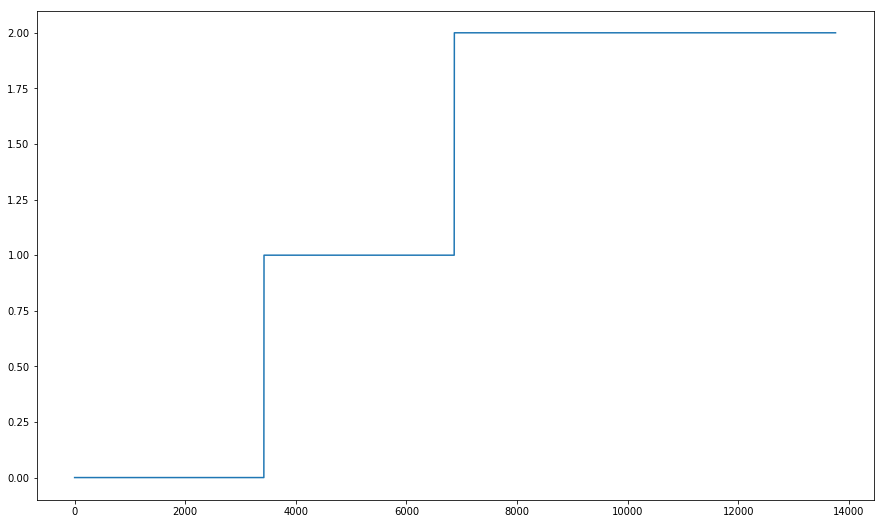

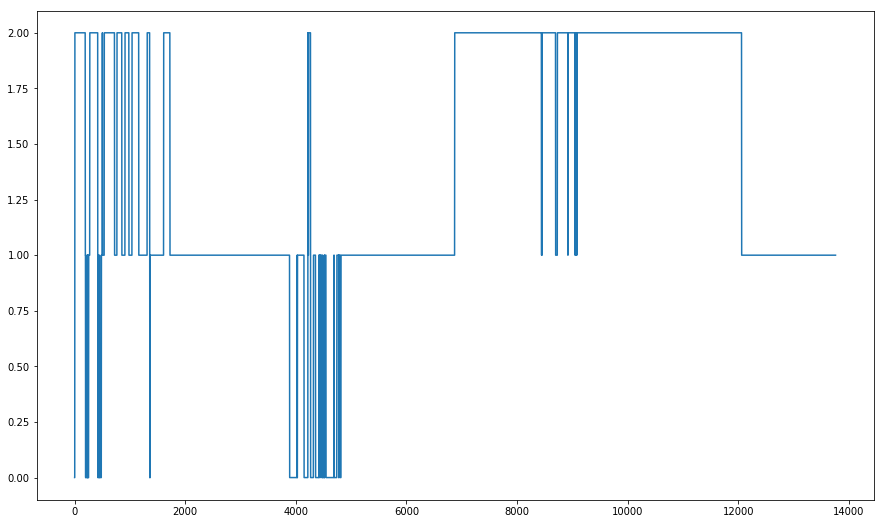

In [16]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

### print true graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true)

### print pred graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))